> 在本文中，我们给出分步骤使用原始的多因子数据，生成目标权重的例子

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.data.dbmodel.models import Uqer
from alphamind.data.dbmodel.models import Universe as UniverseTable
from alphamind.data.dbmodel.models import Industry
from alphamind.data.dbmodel.models import IndexComponent
from alphamind.data import neutralize
from alphamind.portfolio.linearbuilder import linear_builder
from PyFin.api import *
import sqlalchemy as sa
from sqlalchemy import outerjoin, and_, select
from matplotlib import rc
from matplotlib import pyplot as plt
from alphamind.api import *

rc('font', **{'family': 'Microsoft YaHei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 组合构造要求
--------------------------

* 股票池：中证800
* 交易日：2019年1月15日
* alpha因子：$0.5 \times \mathrm{EPS} + 1.5 \times \mathrm{ROE}$
* 行业分类：申万行业一级分类
* 基准指数：中证800指数
* 行业暴露：各行业保持中性
* 个股暴露：个股最大主动暴露不超过2%

In [2]:
universe_name = 'zz800'
trade_date = '2019-01-15'
industry_name = '申万行业分类'
benchmark_code = 906
max_active_industry_exposure = 0.
max_active_single_stock_exposure = 0.02
con = sa.create_engine(os.environ['DB_URI'])

## 2. 获取基本数据
----------------------

### 2.1 获取EPS因子值和ROE因子值，然后相加：

获取在2019年1月15日中证800成分股的EPS, ROETTM因子值

In [3]:
%%time
factor = ['EPS', 'ROE']

big_table = outerjoin(Uqer, UniverseTable, and_(Uqer.trade_date == UniverseTable.trade_date,
                                           Uqer.code == UniverseTable.code))

query = select([Uqer.code] + [getattr(Uqer, f) for f in factor]).select_from(big_table) \
    .where(and_(Uqer.trade_date == trade_date, 
                getattr(UniverseTable, universe_name) == 1))

factors = pd.read_sql(query, con=con)
factors['factor'] = 0.5 * factors['EPS'] + 1.5 * factors['ROE']

Wall time: 454 ms


In [4]:
factors.head()

,code,EPS,ROE,factor
0,1,1.5885,0.1099,0.95910
1,2,1.6891,0.2380,1.20155
2,6,0.4970,0.1742,0.50980
3,8,0.0592,0.1273,0.22055
4,9,0.0612,0.0104,0.04620


### 2.2 或者直接使用Finance - Python的因子计算功能

In [5]:
#

sql_engine = SqlEngine(os.environ['DB_URI'])
factor_expression = 0.5*LAST('EPS') + 1.5*LAST('ROE')
factors2 = sql_engine.fetch_factor_range(universe=Universe(universe_name),
                                         dates=[trade_date],
                                         factors=factor_expression)
factors2.rename(columns={str(factor_expression): 'factor'}, inplace=True)
factors2.head()

,trade_date,factor,code,chgPct,secShortName
0,2019-01-15,0.95910,1,0.0129,平安银行
1,2019-01-15,1.20155,2,0.0056,万科A
2,2019-01-15,0.50980,6,0.0151,深振业A
3,2019-01-15,0.22055,8,0.0075,神州高铁
4,2019-01-15,0.04620,9,0.0089,中国宝安


In [6]:
print(np.testing.assert_array_almost_equal(factors.factor, factors2.factor))

None


### 2.3 获取在2019年1月15日中证800成分股的行业分类

In [7]:
%%time

big_table = outerjoin(Industry, UniverseTable, and_(Industry.trade_date == UniverseTable.trade_date,
                                               Industry.code == UniverseTable.code))

query = select([Industry.code, Industry.industryName1]).select_from(big_table) \
    .where(and_(Industry.trade_date == trade_date,
                Industry.industry == industry_name,
                getattr(UniverseTable, universe_name) == 1))

industry = pd.read_sql(query, con=con)
print(industry.head())

   code industryName1
0     1            银行
1     2           房地产
2     6           房地产
3     8          机械设备
4     9            综合
Wall time: 198 ms


### 2.4 获取在2019年1月15日中证800成分股的指数权重

In [8]:
%%time

big_table = outerjoin(IndexComponent, UniverseTable, and_(IndexComponent.trade_date == UniverseTable.trade_date,
                                                     IndexComponent.code == UniverseTable.code))

query = select([IndexComponent.code, (IndexComponent.weight / 100.).label('index_weight')]) \
    .where(and_(IndexComponent.trade_date == trade_date,
                IndexComponent.indexCode == benchmark_code))

index_components = pd.read_sql(query, con=con)
print(index_components.head())

   code  index_weight
0     1       0.00649
1     2       0.00934
2     6       0.00039
3     8       0.00071
4     9       0.00075
Wall time: 150 ms


In [9]:
df = pd.merge(factors, industry, on=['code'], how='inner').dropna()
df = pd.merge(df, index_components, on=['code'], how='inner').dropna()

## 3. 因子中性化
-------------------

将行业数据（categorical）数据转为dummy矩阵

In [10]:
industry_dummy = pd.get_dummies(df.industryName1)

使用行业dummy矩阵对因子做中性化，得到**行业中性化后**的因子：`neutralized_factor`

In [11]:
%%time

df['neutralized_factor'] = neutralize(industry_dummy.values.astype(float), df['factor'].values).flatten()
print(df[['code', 'neutralized_factor']].head())

   code  neutralized_factor
0     1            0.094060
1     2            0.648652
2     6           -0.043098
3     8           -0.174035
4     9           -0.138300
Wall time: 118 ms


## 4. 组合构建
-----------------------------

### 4.1 使用因子值作为组合权重

使用alpha-mind中的线性优化器来做组合构建，在做组合构建的时候，我们已生成**主动权重**为目标（主动权重 = 组合权重 - 指数权重）。优化器，以最大化组合的预期收益为目标，同时达到以下的限制条件：

* 最小主动权重-2%，同时保证不做空（所以单只股票最小主动权重为-2%与其指数权重负值中的较大值）；
* 最大主动权重2%；
* 行业主动暴露为0；
* 主动权重加和为0，保证组合总权重与指数总权重一致。

In [12]:
er = df.neutralized_factor.values
lbound = np.maximum(-max_active_single_stock_exposure, -df['index_weight'].values)
ubound = max_active_single_stock_exposure
risk_constraints = np.concatenate((industry_dummy, np.ones((len(er), 1))), axis=1)
industry_low_bounds = -max_active_industry_exposure * np.ones(industry_dummy.shape[1])
industry_up_bounds = max_active_industry_exposure * np.ones(industry_dummy.shape[1])
risk_target = (np.concatenate((industry_low_bounds, [0.])),
               np.concatenate((industry_up_bounds, [0.])),)

输出结果中：

* `status`：优化状态；
* `optimized_values`：组合预期收益的负值；
* `weights`：组合中股票的主动权重

In [13]:
%%time

status, optimized_values, weights = linear_builder(er,
                                                   lbound,
                                                   ubound,
                                                   risk_constraints,
                                                   risk_target)

Wall time: 8.97 ms


计算最终持仓：

* `portfolio_weight`：组合权重
* `active_weight`：主动权重

In [14]:
df['portfolio_weight'] = df['index_weight'] + weights
df['active_weight'] = weights

我们可以通过计算行业权重，并与指数的行业权重进行比较，验证行业暴露确实为0

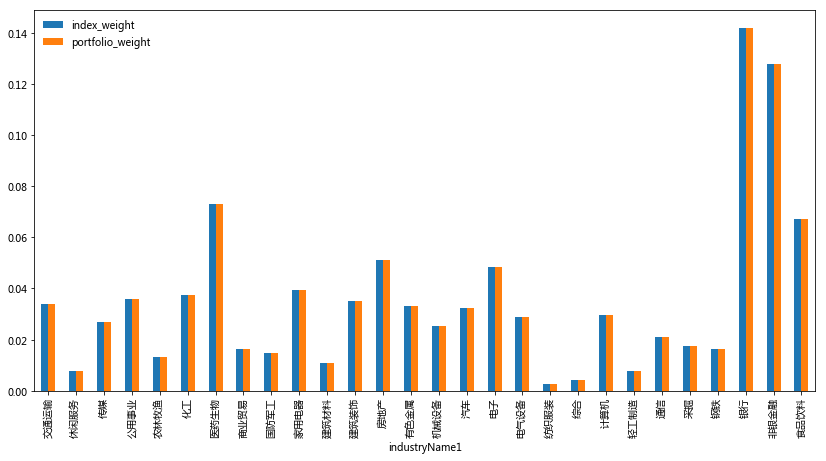

In [15]:
df.groupby('industryName1').sum().plot.bar(y=['index_weight', 'portfolio_weight'], figsize=(14, 7))

我们也可以通过观察中性化后因子值，观察个股权重与因子值的关系

(-0.02, 0.025)

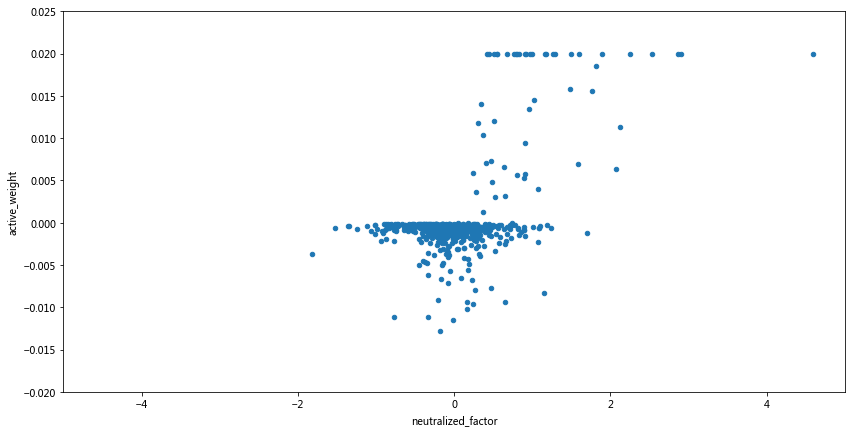

In [16]:
df.plot(kind='scatter', x='neutralized_factor', y='active_weight', figsize=(14, 7))
plt.xlim((-5, 5))
plt.ylim((-0.02, 0.025))

### 4.2 使用每个行业中选择因子值最大的2只股票组成权重

In [17]:
oper = CSTopN('er', 2, groups='industry')
data = df[['code', 'neutralized_factor', 'industryName1']].set_index('code')
data.rename(columns={'neutralized_factor': 'er'}, inplace=True)
data['industry'] = pd.Categorical(data.industryName1).codes.astype(float)

In [18]:
oper.push(data.to_dict(orient='index'))
data['chosen'] = oper.value.to_pd_series()
data = data[data.chosen == True]

所有的行业都选择了两只股票，如下图所示：

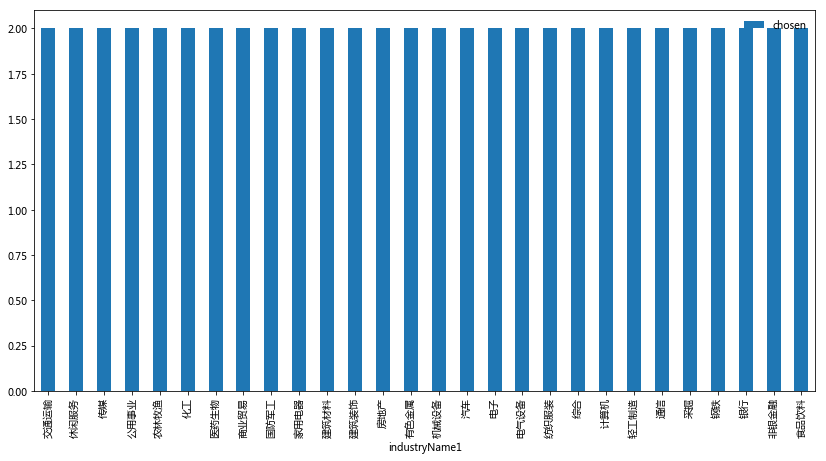

In [19]:
data.groupby('industryName1').count().plot.bar(y=['chosen'], figsize=(14, 7))

In [20]:
data.shape

(56, 4)

股票代码：

In [21]:
data.index

Int64Index([   333,    538,    581,    651,    661,   2008,   2027,   2051,
              2110,   2120,   2304,   2311,   2916, 300033, 300144, 600009,
            600036, 600038, 600104, 600260, 600298, 600309, 600340, 600398,
            600507, 600516, 600519, 600525, 600570, 600585, 600694, 600704,
            600729, 600760, 600801, 600835, 600900, 601088, 601155, 601166,
            601186, 601225, 601318, 601336, 601869, 601877, 601888, 601992,
            603225, 603260, 603444, 603486, 603568, 603816, 603833, 603877],
           dtype='int64', name='code')